In [1]:
from IPython.display import Image

## Word2Vec의 대안으로 사용되는 글로브와 패스트텍스트에 대해서 알아보자.

### 1. GloVE

카운트 기반과, 예측 기반을 모두 사용하는 방법론이다.
기존의 카운트 기반 LSA와 예측 기반의 Word2Vec의 단점을 지적하며 보완 목적으로 나왔다.

#### 1) 기존 방법론에 대한 비판

LSA는 각 단어의 빈도를 카운트한 행렬이라는 전체적인 통계 정보를 입력으로 받아 차원을 축소(Truncated SVD)하여 잠재된 의미를 끌어내는 방법론이다.  
카운트 기반으로 코퍼스의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:?(answer is 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어진다.  

반면 Word2Vec은 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반의 방법론이다. 임베팅 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에, 코퍼스의 전체적인 통계 정보를 반영하지 못한다.  

GloVE는 위 두 가지 방법론을 모두 사용한다.

#### 2) 윈도우 기반 동시 등장 행렬(Window based Co-occurence Matrix)

행과 열을 전체 단어 집합의 단어들로 구성한다.  
i 단어의 Window Size 내에서 k 단어가 등장한 횟수를 (i,k)에 기재한 행렬이다.

예시를 보자.  
I like deep learning  
I like NLP  
I enjoy flying  

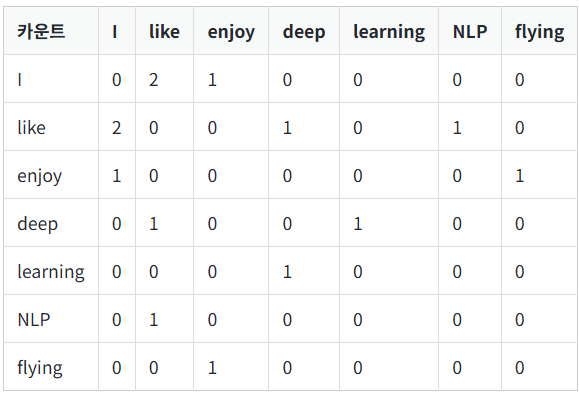

In [2]:
Image("./scr/12-05 window based Co-occurence Matrix.png")

Transpose해도 동일한 행렬이라는 특징이 있다.

#### 3) 동시 등장 확률(Co-occurrence Probability)

동시 등장 확률 $P(k|i)$는 동시 등장 행렬로부터 특정 단어 i의 전체 등장 횟수를 카운트하고,  
특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률이다.

즉, (i행의 k열의 값)/(i행의 모든 값을 더한 합)이다.

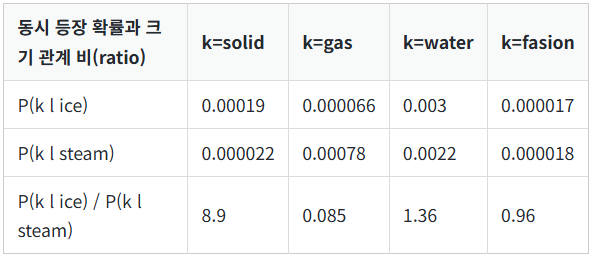

In [3]:
Image("./scr/12-05 Co-occurence Probability.png")

위 표는 GloVe의 제안 논문에서 가져온 예시 표이다.  
ice가 등장했을 때, steam이 등장한 확률 대비,  
ice가 등장했을 때, solid가 등장한 확률은 약 8.9배 더 크다.

#### 4) 손실 함수(Loss function)

용어를 정리하자.

- $X$ : 동시 등장 행렬(Co-occurrence Matrix)  
- $X_{ij}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 j가 등장하는 횟수  
- $X_{i} : \sum_{j}{X_{ij}}$ : 동시 등장 행렬에서 i행의 값을 모두 더한 값  
- $P_{ik}$ : $P(k\ |\ i)$ = $\frac{X_{ik}}{X_{i}}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 k가 등장할 확률    
Ex) P(solid l ice) = 단어 ice가 등장했을 때 단어 solid가 등장할 확률  
 
- $\frac{P_{ik}}{P_{jk}}$: $P_{ik}$를 $P_{jk}$로 나눠준 값  
Ex) P(solid l ice) / P(solid l steam) = 8.9  
- $w_{i}$ : 중심 단어 i의 임베딩 벡터  
- $\tilde{w_{k}}$ : 주변 단어 k의 임베딩 벡터  

GloVe의 아이디어를 한 줄로 요약하면  
'임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서의 동시 등장 확률이 되도록 만드는 것'이다. 즉, 이를 만족하도록 임베딩 벡터를 만드는 것이 목표이다. 이를 식으로 표현하면 다음과 같다.  

$dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ P(k\ |\ i) = P_{ik}$

더 정확히는 아래와 같다.  
$dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ log\ P(k\ |\ i) = log\ P_{ik}$

손실 함수를 처음부터 설계해보자.  
중요한 것은 단어 간의 관계를 잘 표현하는 함수여야 한다는 것이다.  
이를 위해 $P_{ik} / P_{jk}$를 식에 사용한다.  
Ex) P(solid l ice) / P(solid l steam) = 8.9  

연구진은  
$F(w_{i},\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  
초기 식으로 전개를 시작한다.  

함수 F는 두 단어 사이의 동시 등장 확률의 크기 관계 비율(ratio) 정보를 벡터 공간에 인코딩하는 것이 목적이다. 이를 위해 GloVe 연구진들은 $w_{i}$와, $w_{j}$라는 두 벡터의 차이를 함수 $F$의 입력으로 사용하는 것을 제안한다.  

$F(w_{i} -\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  

그런데 우변은 스칼라값이고 좌변은 벡터값이다.  
이를 성립시키기 위해서 함수 $F$의 입력에 내적을 수행한다.  
$F((w_{i} -\ w_{j})^{T} \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$  

정리하면, 선형 공간(Linear space)에서 단어의 의미 관계를 표현하기 위해 뺄셈과 내적을 택했다.  


---
여기서부터 이해가 안가서 나는 아래 사이트를 공부했다.  
https://nlp.stanford.edu/projects/glove/  

논문에서 말하길,  
'Since vector spaces are inherently linear structures, the most natural way to do this is with vector differences.'  

내가 궁금한 것은, 단어 간의 의미 관계를 표현하는데,  
어떻게 임베딩 벡터들끼리의 뺄셈으로 그 의미 관계가 encoding될 수 있냐는 것이다.  
즉, 정확히 말하자면,  
'임의의 벡터들에 규칙성이 없는데 어떻게 뺄셈으로 정보를 인코딩할 수 있는가'

Perplexity 말로는,  
'임의의 벡터'는 실제로 임의가 아니다. 라고 설명해준다.  
"""
즉, 임베딩 벡터는 처음에는 랜덤하게 초기화되지만, 학습 과정에서 특정한 목적 함수를 최소화하도록 조정된다.  
GloVe의 경우 다음과 같은 가중 최소제곱 회귀(Weighted least squares) 목적 함수를 사용한다."""  
는 것이다. 

250418  
추가하자면, 그 의미 관계는 앞서 봤던 $\frac{P_{ik}}{P_{jk}}$의 값으로 볼 수 있었다.   

---

함수 $F$는 Homomorphism을 만족해야한다.  
$F(a+b) = F(a)F(b)$가 되어야 한다는 것이다.  

---

가 이해가 안가서 추가로 자료를 찾아봤다.  
이후 이 블로그를 참조했다.  
https://soki.tistory.com/93

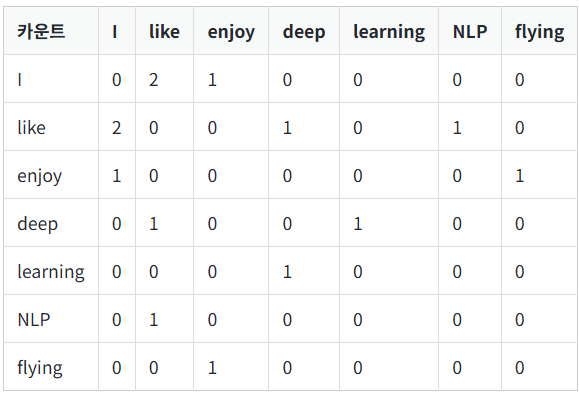

In [4]:
Image("./scr/12-05 window based Co-occurence Matrix.png")

위 이미지를 다시 보자.  
동시발생 행렬을 보니, target과 context 단어가 구분되지 않는다.  
즉, 위 행렬에서 target단어 행, context단어 열은 동일한 단어집합이다.  
바뀌어도 무관하다는 것이다.  
이를 수식으로 표현하면,  
$w \leftrightarrow \tilde{w}$  
$X \leftrightarrow X^{T}$  

Homomorphism이란, 동일한 종류의 대수적 구조 사이에 정의된 대수적 구조를 보존하는 함수이다.  
우리가 사용중인 대수적 구조는 선형 공간이고, 덧셈 연산이 곱셈 연산으로 mapping되어야 한다.
    
$F(a+b) = F(a) \times F(b)$   
그런데, homomorphism은 inverse를 허용한다. 즉 다음이 가능하다.  
$F(a-b) = F(a) / F(b)$   

이후는 해당 포스트의 출처인 아래의 강의를 참고했다.  

---

여기서부터 이해 보강을 위해 아래 강의 영상을 참고했다.  
https://www.youtube.com/watch?v=JZI74rrMb_M  
(05-3: Text Representation II - Distributed Representation Part 3 (GloVe & FastText))  특히, 09:01부터가 도움이 됐다.   

 - $w_{i}$ : 중심 단어 i의 임베딩 벡터  : ice, steam
- $\tilde{w_{k}}$ : 주변 단어(context word) k의 임베딩 벡터  : solid  

input : $(\mathbb{R}, +)$을, 선형공간의 입력이  
output : $(\mathbb{R}>0, \times)$ 출력에서는 곱셈으로 나오게 mapping 해줘야 한다는 뜻이다.  

$$w^{T}\tilde{w} = (w_{i} - w_{j})^{T}\tilde{w_{k}} + (w_{j})^{T}\tilde{w_{k}}$$
*위 식은 항등식이다. 좌우변을 같게 우변으로 변형한 것 뿐이다.
$$F(w^{T}\tilde{w}) = F((w_{i} - w_{j})^{T}\tilde{w_{k}} + w_{j}^{T}\tilde{w_{k}})$$ 
$$\qquad\qquad\qquad =F((w_{i} - w_{j})^{T}\tilde{w_{k}}) + F(w_{j}^{T}\tilde{w_{k}})$$

여기서 우변의 $F(w_{j}^{T}\tilde{w_{k}})$를 좌변으로 이항하면,
$$F((w_{i} - w_{j})^{T}\tilde{w_{k}}) = \cfrac{F(w_{i}^{T}\tilde{w_{k}})}{F(w_{j}^{T}\tilde{w_{k}})} = \cfrac{P_{ik}}{P_{jk}}$$  

Finally, we can drive that $F(x) = exp(x)$

- We know that   
$F(x) = exp(x)$ and  
$F((w_{i} - w_{j})^{T}\tilde{w_{k}}) = \cfrac{F(w_{i}^{T}\tilde{w_{k}})}{F(w_{j}^{T}\tilde{w_{k}})} = \cfrac{P_{ik}}{P_{jk}}$

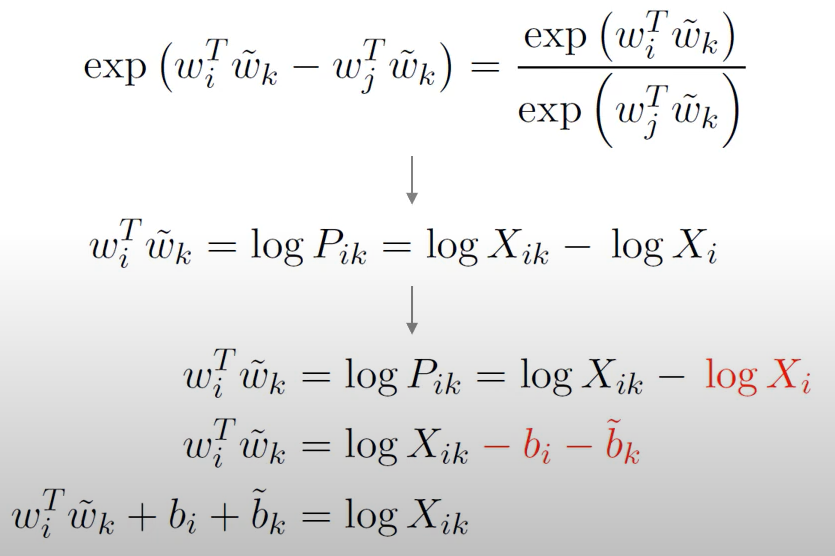

In [5]:
Image("./scr/12-05 exp.png")

알게 된 사실인, 지수함수라는 점을 대입한다.  
이때, 다음 줄에서 양변에 로그를 취하면 exp는 사라진다. 이때, $logP_{ik}$는 정의상 $log\frac{X_{ik}}{X_{i}}$가 된다.  
이후 식을 아래로 전개하되, $X_{i}$를 상수화한다.  
    연구진들은 polymomorphism 성립을 위해 위와 같이 상수화했다고 한다.  
그리고 식을 전개하면 최종 아래와 같은 식이 나오는 것이다.  

$$w_{i}^{T}\tilde{w_{k}} + b_{i} + \tilde{b_{k}} = log\ X_{ik}$$

---

(돌아와서)  
우변의 값과의 차이를 최소화하는 방향으로 좌변의 4개 항은 학습을 통해 값이 바뀌는 변수들이 된다.  

일반화하면 아래와 같다.  
$$Loss\ function = \sum_{m, n=1}^{V}\ (w_{m}^{T}\tilde{w_{n}} + b_{m} + \tilde{b_{n}} - logX_{mn})^{2}$$

이때 $V$는 단어집합의 크기이다.  

하지만 여전히 문제점이 있다.  
동시 등장 행렬 $X$가 희소 행렬(Sparse Matrix)일 가능성이 높다는 점이다.  
많은 값이 0이거나, 동시 등장 빈도가 적어서 많은 값이 작은 수치를 갖는 경우가 많다.  
따라서 연구팀은 Weighting function $f(X_{ik})$을 손실 함수에 도입했다.  

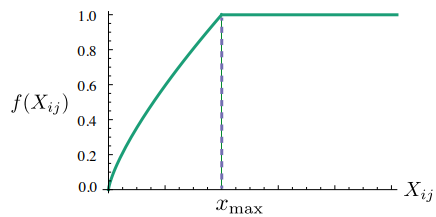

In [6]:
Image("./scr/12-05 weighting function.png")

$X_{ik}$값이 작으면 함수의 값을 작게 하고,  
값이 크면 함수의 값을 크게 한다.  
다만, 빈도수가 높은 단어들이 너무 지나친 가중을 받게 해서도 안 될 것이다. 'It is' 같은.  

이 함수 $f(x)$의 식은 다음과 같이 정의된다.  
$f(x) = min(1,\ (x/x_{max})^{3/4})$

최종 손실 함수는 아래와 같다.  
$Loss\ function = \sum_{m, n=1}^{V}\ f(X_{mn})(w_{m}^{T}\tilde{w_{n}} + b_{m} + \tilde{b_{n}} - logX_{mn})^{2}$

### 2. FastText

FastText에서 각 단어는 글자 단위 n-gram의 구성으로 취급한다.    
n을 몇으로 결정하느냐에 따라 단어들이 얼마나 분리되는지 결정된다.      
예를 들어서 n=3인 tri-gram의 경우, apple은 app,ppl,ple로 분리하고 이를 벡터로 만든다.  

여기에 <>를 토큰 양 끝에 붙인다.  
그리고 n의 최솟값, 최댓값으로 범위를 설정한다.  
예를 들어 최솟값 3, 최댓값 6이라면 다음과 같다. 

n = 3 ~ 6인 경우  
<ap, app, ppl, ppl, le>, <app, appl, pple, ple>, <appl, pple>, ..., <apple>

그리고 저 단어들에 대해서 Word2Vec을 수행한다.

#### 1) 모르는 단어(OOV, Out of Vocabulary)에 대한 대응

모든 단어의 각 n-gram에 대해서 워드 임베딩이 된다.  
모르는 단어라도 Subword를 통해 다른 단어와의 유사도를 계산할 수 있다. 예를 들어 birthplace가 OOV라고 해도, birth, place가 내부 단어로 있었다면 벡터를 얻을 수 있다. 

#### 2) 단어 집합 내 빈도 수가 적었던 단어(Rare Word)

마찬가지의 이유로 희귀 단어라도, 그 단어의 n-gram이 겹친다면, Word2Vec에 비해 비교적 높은 임베딩 벡터값을 얻을 수 있다.

이는 FastText가 노이즈가 많은 코퍼스에서 강점을 갖는 이유이기도 하다.  

#### 3) 실습으로 비교하는 Word2Vec Vs. FastText

In [10]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [11]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1e83d6be900>)

In [12]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yusj0\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [13]:
targetXML = open('ted_en-20160408.xml','r',encoding='UTF-8')
target_text = etree.parse(targetXML)    

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [14]:
print(f'총 샘플의 개수 : {len(result)}')

총 샘플의 개수 : 273424


In [15]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [16]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5,workers=4, sg=0)

In [17]:
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8620918989181519), ('guy', 0.8154783844947815), ('boy', 0.7900412678718567), ('lady', 0.7627538442611694), ('soldier', 0.7581015229225159), ('girl', 0.7501546740531921), ('gentleman', 0.7206425666809082), ('kid', 0.7120600938796997), ('poet', 0.6830198168754578), ('dancer', 0.6821439862251282)]


In [18]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 모델 로드

In [19]:
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8620918989181519), ('guy', 0.8154783844947815), ('boy', 0.7900412678718567), ('lady', 0.7627538442611694), ('soldier', 0.7581015229225159), ('girl', 0.7501546740531921), ('gentleman', 0.7206425666809082), ('kid', 0.7120600938796997), ('poet', 0.6830198168754578), ('dancer', 0.6821439862251282)]


#### Word2Vec

이전의 실습에서의 모델에, electrofishing과 유사한 단어를 찾아보자.

In [20]:
model_result = model.wv.most_similar('electrofishing')
print(model_result)

KeyError: "Key 'electrofishing' not present in vocabulary"

단어 집합에 electrofishing이 존재하지 않는다고 뜬다.  
이처럼 Word2Vec은 학습 데이터에 존재하지 않는 단어, 즉 모르는 단어에 대해서는 단어의 유사도를 계산할 수 없다.

#### FastText

In [21]:
from gensim.models import FastText

model = FastText(result, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [22]:
model.wv.most_similar("electrofishing")

[('electrolux', 0.8659774661064148),
 ('electrolyte', 0.8621833324432373),
 ('electro', 0.8560667634010315),
 ('electroshock', 0.8492816090583801),
 ('electroencephalogram', 0.8400212526321411),
 ('electrochemical', 0.8291620016098022),
 ('electronic', 0.8274754881858826),
 ('electric', 0.827053964138031),
 ('electrogram', 0.8253097534179688),
 ('electron', 0.8151677250862122)]

FastText는 유사한 단어를 계산해서 출력하고 있음을 볼 수 있다.

#### 4) 한국어에서의 FastText

한국어에서도 OOV 문제를 해결하기 위해 FastText 적용 시도가 있었다.  